# Capstone Project - The Battle of the Neighborhoods

## Table of contents
* [A. Introduction](#introduction)
* [B. Data](#data)
* [C. Methodology](#methodology)
* [D. Results](#results)
* [E. Discussion](#discussion)
* [F. Conclusion](#conclusion)

## A. Introduction  <a name="introduction"></a>

Allocating police resources is a challenging endeavor. It’s likely that certain types of crime occur in certain areas and types of venues. If police had a better idea of where specific crimes, and crime in general occur, they will be able to more efficiently distribute their resources (manpower, equipment, etc.) and implement preventative measures. For example, if they noticed that a lot of theft occurs near bars, they may ask owners of bars to inform their customers to exercise caution especially when intoxicated since it is possible that people under the influence make prime targets for theft. Another example could be if it were found that drug possessions were found to occur in or near movie theatres. In this case, police may consider dispatching drug sniffing dogs in or near theatres. After implementing these measures, they could then consult the city crime statistics once more to see their if measures showed signs of success. The target audience of this project is specifically the Chicago PD of Illinois.

##  B. Data <a name="data"></a>

We will be using 2 sets of data, venue data from the Foursquare API and official crime data for the city of Chicago, IL. From the venue data, we will create a dataframe containing the category, longitude, and latitude of hundreds of venues of many types. From the crime data, we will create a dataframe containing the date, type, description, and coordinates of hundreds of thousands of criminal incidents. Then from these 2 dataframes, we will create a new dataframe called crime_by_venue where the index or row labels are types of crimes and the column labels are types of venues. For each cell in the dataframe or matrix, the cell in row i and column j represents the number of incidents of crime i at venues of type j. For example, if the cell in row ‘Battery’ and columns ‘Chinese Restaurant’ is 12, then in the past year there were 12 incidents of battery within 0.1 miles of a Chinese restaurant. 

https://data.cityofchicago.org/Public-Safety/Crimes-Map/dfnk-7re6

In [121]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
address = 'Chicago, IL'
geolocator = Nominatim(user_agent="city_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinates of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinates of Chicago, IL are 41.8755616, -87.6244212.


In [3]:
local_filepath = '..\\foursquare_credentials.txt'
f = open(local_filepath, "r")
contents = f.read()
credentials = json.loads(contents)
f.close()

CLIENT_ID = credentials['CLIENT_ID']
CLIENT_SECRET = credentials['CLIENT_SECRET']
VERSION = credentials['VERSION']

In [4]:
LIMIT = 1000
def getNearbyVenues(latitudes, longitudes, radius=500):
    
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
         
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        venues_list.append([(
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [ 
                  'Venue Category',
                  'Venue Latitude', 
                  'Venue Longitude']
    return(nearby_venues)

In [5]:
df = getNearbyVenues([latitude], [longitude])

In [6]:
df.shape

(100, 3)

In [7]:
df.head()

,Venue Category,Venue Latitude,Venue Longitude
0,Theater,41.876058,-87.625303
1,Cuban Restaurant,41.875724,-87.626386
2,Sushi Restaurant,41.876969,-87.624534
3,Hostel,41.875757,-87.626537
4,Donut Shop,41.876768,-87.624575


In [8]:
onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")
fixed_columns = list(onehot.columns)#[onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

In [9]:
onehot.shape

(100, 63)

In [10]:
onehot.head(3)

,American Restaurant,Arepa Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bookstore,Boutique,Bubble Tea Shop,Building,...,Sandwich Place,Snack Place,Spanish Restaurant,Speakeasy,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Trail,Whisky Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [11]:
venue_categories = list(onehot.columns)
print(len(venue_categories))
print(venue_categories[:5])

63
['American Restaurant', 'Arepa Restaurant', 'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant']


In [12]:
file_path = 'chicago_crime.csv'
crime_df = pd.read_csv(file_path)

In [13]:
crime_df.dropna(inplace=True)
crime_df.reset_index(inplace=True, drop=True);

In [14]:
print(crime_df.shape)
crime_df.head()

(254366, 5)


,DATE OF OCCURRENCE,PRIMARY DESCRIPTION,LOCATION DESCRIPTION,LATITUDE,LONGITUDE
0,6/24/2019 18:24,BATTERY,SIDEWALK,41.753506,-87.665947
1,12/5/2019 18:43,NARCOTICS,SIDEWALK,41.862559,-87.721771
2,6/24/2019 11:00,THEFT,STREET,41.992936,-87.700697
3,11/19/2019 19:20,THEFT,CTA BUS,41.778768,-87.683628
4,11/19/2019 0:10,BATTERY,APARTMENT,41.883109,-87.760218


In [253]:
crime_categories = list(crime_df['PRIMARY DESCRIPTION'].unique())
crime_categories[:5]

['BATTERY', 'NARCOTICS', 'THEFT', 'CRIMINAL DAMAGE', 'KIDNAPPING']

## C. Methodology <a name="methodology"></a>

A good question to ask would be what does it mean for a crime to have occured near a type of venue. In this analysis, we will determine near to mean less than 0.1 miles or 0.16 km.

The steps that will be taken for processing the crime and venue dataframes are
<ol>
<li>loop through each type of crime (Battery, Theft, etc...)</li>
    <ol>
    <li>from the crime dataframe, get all crime incidents of this type</li>
    <li>loop through each of these incidents</li>
        <ol>
        <li>loop through each type of venue (Restaurant, Movie Theatre, etc...)</li>
            <ol>
            <li>from the venue dataframe, get all venues of this type</li>
                <ol>
                <li>loop through each of these venues</li>
                    <ul>
                    <li>check if the current crime incident has occured within 0.1 miles of this venue. If it has, increment its respective cell in the crime_by_venue dataframe by 1</li>
                    </ul>
                </ol>
            </ol>
        </ol>
    </ol>
</ol>

In [16]:
crime_by_venue = pd.DataFrame(index=crime_categories, columns=venue_categories).fillna(value=0)

In [17]:
crime_by_venue

,American Restaurant,Arepa Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bookstore,Boutique,Bubble Tea Shop,Building,...,Sandwich Place,Snack Place,Spanish Restaurant,Speakeasy,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Trail,Whisky Bar
BATTERY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NARCOTICS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
THEFT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CRIMINAL DAMAGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIDNAPPING,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DECEPTIVE PRACTICE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WEAPONS VIOLATION,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CRIMINAL TRESPASS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ASSAULT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OTHER OFFENSE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
from time import sleep

In [232]:
print('1', end='\r')
sleep(2)
print('2', end='\r')

In [254]:
num_crimecats = len(crime_categories)
percent = 0
counter = 0
progress_bar = ' '*num_crimecats

for crime_type in crime_categories:
    percent = round((counter/num_crimecats)*100, 0)
    progress_bar = '#'*counter + ' '*(num_crimecats-counter)
    print(f'{percent}% [{progress_bar}]', end='\r')
    crimes_of_this_type = crime_df[crime_df['PRIMARY DESCRIPTION'] == crime_type][:500]
    for incident in crimes_of_this_type.iterrows():
        crime = incident[1][1]
        crime_location = (incident[1][3], incident[1][4])
        for venue_type in venue_categories:
            #print(f'\tVenue type: {venue_type}')
            venues_of_this_type = df[df['Venue Category'] == venue_type].head(100)
            for venue_ in venues_of_this_type.iterrows():
                venue = venue_[1]['Venue Category']
                venue_location = (venue_[1]['Venue Latitude'], venue_[1]['Venue Longitude'])
                distance = geodesic(crime_location, venue_location).miles
                if distance < 0.1:
                    crime_by_venue.loc[crime][venue] += 1
    counter += 1
    
percent = round((counter/num_crimecats)*100, 0)
progress_bar = '#'*counter + ' '*(num_crimecats-counter)
print(f'{percent}% [{progress_bar}]', end='\r')

In [255]:
crime_by_venue

,American Restaurant,Arepa Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bookstore,Boutique,Bubble Tea Shop,Building,...,Sandwich Place,Snack Place,Spanish Restaurant,Speakeasy,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Trail,Whisky Bar
BATTERY,3,5,3,0,10,4,4,5,1,1,...,12,1,0,3,0,0,1,3,0,4
NARCOTICS,0,0,0,0,0,0,1,1,1,0,...,2,1,0,1,0,0,0,0,0,0
THEFT,1,0,0,0,0,1,3,1,1,1,...,4,1,1,1,0,1,0,1,0,0
CRIMINAL DAMAGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIDNAPPING,0,0,0,0,0,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,0
DECEPTIVE PRACTICE,2,3,2,1,7,2,4,1,3,1,...,8,3,0,1,2,0,1,1,0,3
WEAPONS VIOLATION,2,0,0,0,0,0,0,2,0,2,...,2,0,0,0,0,0,0,0,0,0
CRIMINAL TRESPASS,0,2,1,0,4,1,3,1,2,0,...,5,1,0,1,0,0,0,1,0,2
ASSAULT,0,1,2,0,3,0,1,0,1,0,...,4,1,2,1,0,2,0,2,0,1
OTHER OFFENSE,1,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [256]:
# lets drop all rows whose columns are all zeros 
# (corresponds to a type of crime that has not occured at any of these venue types)
crime_by_venue_droprowswithallzeros = crime_by_venue.loc[(crime_by_venue!=0).any(axis=1)]
# lets split the dataframe into a left half and right half to make it easier to visualize
half_num_cols = int(crime_by_venue_droprowswithallzeros.shape[1]/2)-1
crime_by_venue_lefthalf  = crime_by_venue_droprowswithallzeros.iloc[:, :half_num_cols]
crime_by_venue_righthalf = crime_by_venue_droprowswithallzeros.iloc[:, half_num_cols:]

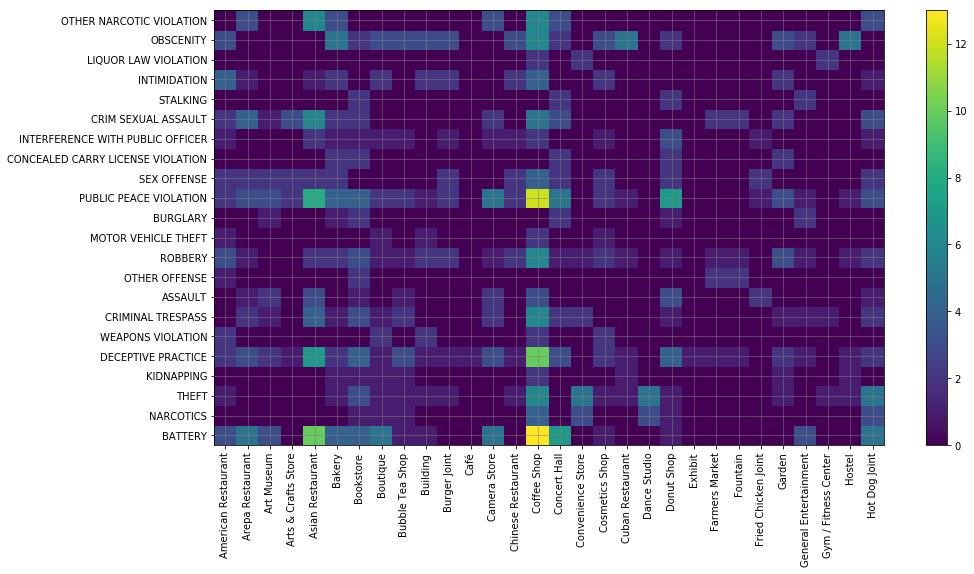

In [257]:
# color map of the left half. Colors indicate the number of incidents of the crime on the y axis occuring
# at venues on the x axis
fig, ax = plt.subplots(figsize=(15, 8))

num_rows, num_columns = crime_by_venue_lefthalf.shape
plt.pcolor(crime_by_venue_lefthalf)
plt.yticks(np.arange(0.5, num_rows, 1), crime_by_venue_lefthalf.index)
plt.xticks(np.arange(0.5, num_columns, 1), crime_by_venue_lefthalf.columns, rotation=90)
plt.colorbar(orientation='vertical')
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()

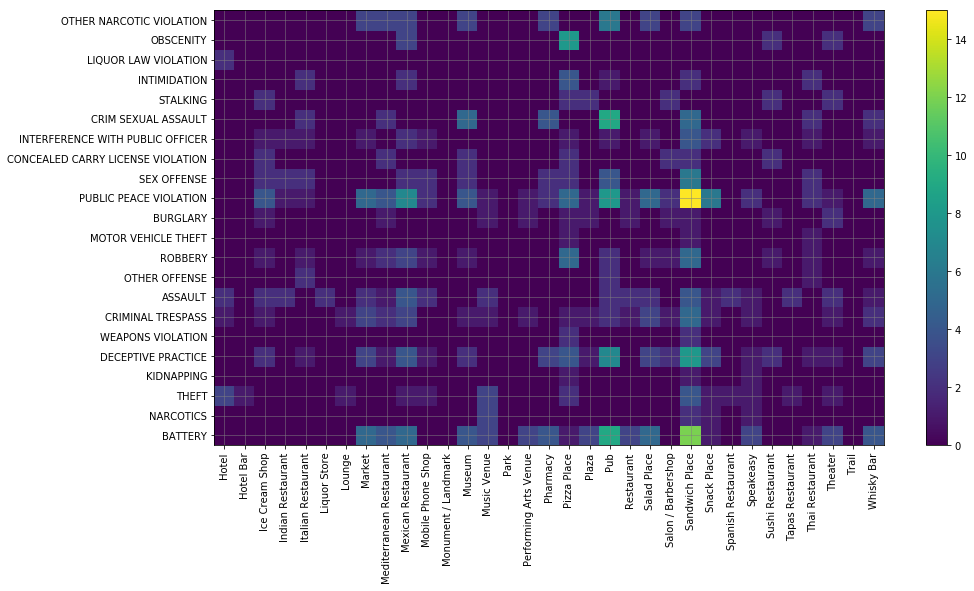

In [258]:
# color map of the right half
fig = plt.figure(figsize=(15, 8))

num_rows, num_columns = crime_by_venue_righthalf.shape
plt.pcolor(crime_by_venue_righthalf)
plt.yticks(np.arange(0.5, num_rows, 1), crime_by_venue_righthalf.index)
plt.xticks(np.arange(0.5, num_columns, 1), crime_by_venue_righthalf.columns, rotation=90)
plt.colorbar(orientation='vertical')
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()

##  D. Results <a name="results"></a>

To be added in week 5

##  E. Discussion <a name="discussion"></a>

To be added in week 5

## F. Conclusion <a name="conclusion"></a>

To be added in week 5